In [ ]:
%matplotlib inline
import scipy.io.wavfile as wavfile
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio

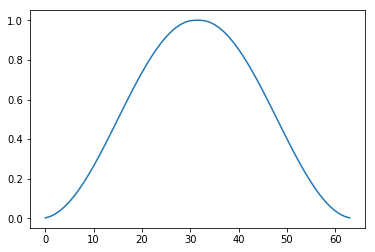

In [152]:
fft_size = 64
hop_size = fft_size // 4
window_half_size = fft_size // 2
window = np.zeros((fft_size,))
halfwin = 0.5 * (1+np.cos(np.pi*np.arange(0, window_half_size)/window_half_size))
window[window_half_size: fft_size] = halfwin
window[0:window_half_size] = halfwin[::-1]
plt.plot(window)

In [153]:
def draw_spectrogram(data):
    spectrogram_size = len(range(0, len(data)-fft_size, hop_size))
    spectrogram = np.empty((spectrogram_size, fft_size), dtype=np.complex64)
    z = 0
    for t in range(0, len(data)-fft_size, hop_size):
        windowed_data = data[t:t+fft_size]*window
        spectrogram[z] = np.fft.fft(data[t:t+fft_size] * window)
        z = z+1
    plt.pcolormesh(np.arange(spectrogram_size) * hop_size / sr,
                   np.arange(fft_size) * sr / fft_size,
                   20 * np.log(np.abs(spectrogram.T)))
    plt.show()

In [190]:
def transform1(data):
    phase = np.zeros(64)
    buffer = np.zeros(48)
    output = np.zeros(len(data))
    t = 0
    while t < len(data) - 80:
        a1 = data[t:t+64];
        a2 = data[t+16:t+80];
        s1 = np.fft.fft(a1 * window)
        s2 = np.fft.fft(a2 * window)
        phase = (phase + np.angle(s2) - np.angle(s1)) % (2*np.pi)
        new_data = np.real(np.fft.ifft(np.abs(s2)*np.exp(1j*phase))) * window
        for i in range(48):
            idx = int(i*4/3)
            buffer[i] += new_data[idx]
        output[t:t+12] = buffer[:12]
        buffer = np.concatenate((buffer[12:48], np.zeros(12)))
        t += 12
    return output

In [192]:
def transform2(data):
    phase = np.zeros(64)
    buffer = np.zeros(96)
    output = np.zeros(len(data))
    t = 0
    while t < len(data) - 80:
        a1 = data[t:t+64];
        a2 = data[t+16:t+80];
        s1 = np.fft.fft(a1 * window)
        s2 = np.fft.fft(a2 * window)
        phase = (phase + np.angle(s2) - np.angle(s1)) % (2*np.pi)
        new_data = np.real(np.fft.ifft(np.abs(s2)*np.exp(1j*phase))) * window
        for i in range(96):
            idx = int(i*2/3)
            buffer[i] += new_data[idx]
        output[t:t+24] = buffer[:24]
        buffer = np.concatenate((buffer[24:96], np.zeros(24)))
        t += 24
    return output

In [201]:
sr, data = wavfile.read('cnn.wav')
ratio = sr / 8000
data = np.interp(np.arange(0, len(data), ratio), np.arange(0, len(data)), data)
data = data[100000:200000]
sr = 8000
print((data**2).mean())
Audio(data, rate=sr)

2359276.00314


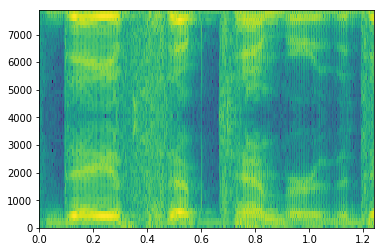

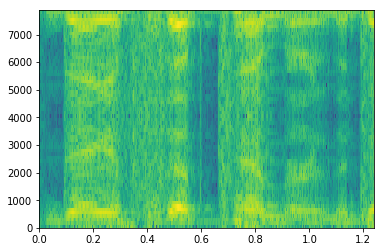

2609061.93113


In [202]:
result1 = transform1(data) # transform(data, 4/3)
draw_spectrogram(data[:10000])
draw_spectrogram(result1[:10000])
print((result1**2).mean())
Audio(result1, rate=sr)

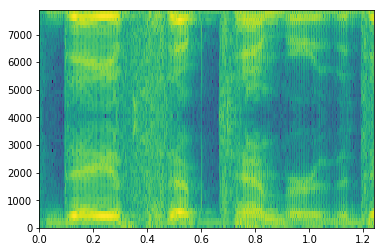

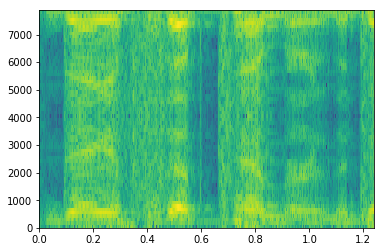

2884866.87837


In [203]:
result2 = transform2(data) # transform(data, 2/3)
draw_spectrogram(data[:10000])
draw_spectrogram(result1[:10000])
print((result2**2).mean())
Audio(result2, rate=sr)

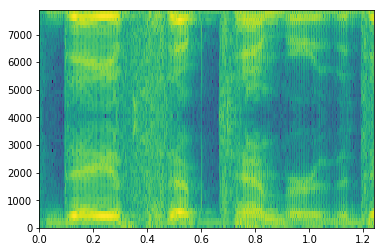

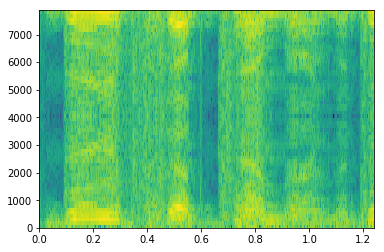

5466555.71878


In [204]:
result3 = result1 + result2
draw_spectrogram(data[:10000])
draw_spectrogram(result3[:10000])
print((result3**2).mean())
Audio(result3, rate=sr)

In [161]:
def transform(data, ratio):
    phase = np.zeros(fft_size)
    result = np.zeros(math.ceil(len(data) * ratio) + fft_size)
    t = 0
    while t < len(data)-(fft_size+hop_size):
        index = int(t)
        a1 = data[index:index+fft_size]
        a2 = data[index+hop_size:index+hop_size+fft_size]
        s1 = np.fft.fft(a1 * window)
        s2 = np.fft.fft(a2 * window)
        phase = (phase + np.angle(s2) - np.angle(s1)) % (2*np.pi)
        new_data = np.real(np.fft.ifft(np.abs(s2)*np.exp(1j*phase)))
        result_index = int(t * ratio)
        result[result_index:result_index+fft_size] += new_data * window
        t += hop_size / ratio
    result = np.interp(np.arange(0, len(result), ratio), np.arange(0, len(result)), result)
    return result[:len(data)]